# MOF Recommender System: Constructing a matrix with Henry coefficients from the Sparsity Matrix

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pprint
import os
import pygaps
import seaborn as sns
from scipy import stats
import scipy
from sklearn.ensemble import IsolationForest

### Load in the Sparsity Matrix and other relevant files

In [2]:
material_gas_df = pd.read_csv('data/material_gas_dataframe.csv')
material_gas_df.set_index(list(material_gas_df)[0], inplace=True)
material_gas_df[material_gas_df.columns[0:5]][0:5]

,CURLTUGMZLYLDI-UHFFFAOYSA-N_298K,IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K,VNWKTOKETHGBQD-UHFFFAOYSA-N_298K,MYMOFIZGZYHOMD-UHFFFAOYSA-N_298K,QQONPFPTGQHPMA-UHFFFAOYSA-N_298K
Unnamed: 0,,,,,
NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,1,1,1,0,1
NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,1,1,1,1,1
NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,1,1,1,1,0
NIST-MATDB-1b85b1862d4e9cc2e0f46d0e2698ab79,1,1,1,1,0
NIST-MATDB-991daf7313251e7e607e2bab2da57e33,1,1,1,1,1


In [3]:
with open('data/material_gas_to_filename.json') as infile:
    material_gas_to_filename = json.load(infile)

### We will need a function to convert the units of the isotherms for consistency's sake

#### First we need to be able to compute the molecular weight of the adsorbates

In [4]:
# Lets start by getting the molecular formula in a dictionary:
url = "https://adsorbents.nist.gov/isodb/api/gas/"

inchikey_to_formula = {}
for inchikey_temp in material_gas_df.columns:
    inchikey = inchikey_temp.split('_')[0]
    gas_data = json.loads(requests.get(url + inchikey + '.json').content)
    inchikey_to_formula[inchikey] = gas_data['formula']

# Lets also load in the atomic masses of each element:
atomic_masses = pd.read_csv('data/atomicmasses.csv')

In [5]:
def formula_to_mw(formula):
    # This splits the formula up into elements plus their frequency
    start_i = 0
    elements = []
    for end_i, letter in enumerate(formula[1:], start=1):
        if letter.isupper():
            elements.append([start_i, end_i])
            start_i = end_i
    elements.append([start_i, len(formula)])
       
    # This calculates the molecular weight of each type of element
    total_mw = 0
    for element in elements:
        form = formula[element[0]:element[1]]
        for i, letter in enumerate(form):
            if letter.isdigit():
                element_mw = np.float(atomic_masses[atomic_masses.atom == form[:i]]['mass'])
                total_mw = total_mw + element_mw * np.int(form[i:])
                break
            if form.isalpha():
                element_mw = np.float(atomic_masses[atomic_masses.atom == form]['mass'])
                total_mw = total_mw + element_mw
                break
    return total_mw

assert formula_to_mw('N2O') == (2 * np.float(atomic_masses[atomic_masses.atom == 'N']['mass']) 
                                + np.float(atomic_masses[atomic_masses.atom == 'O']['mass']))
assert formula_to_mw('CH3OH') == (np.float(atomic_masses[atomic_masses.atom == 'C']['mass'])
                                  + np.float(atomic_masses[atomic_masses.atom == 'O']['mass'])
                                  + 4 * np.float(atomic_masses[atomic_masses.atom == 'H']['mass']))

In [6]:
# Takes in the filename of an isotherm (stored in the isotherm's `.json` file), 
#  reads it and converts units to bar (for pressure) and mmol/g (for adsorption) if needed.
# Returns pressure and adsorption in np.arrays
# An example of use is:
#     `pressure, adsorption = read_isotherm_and_convert_units('10.1002adfm.200500561.Isotherm4')
def read_isotherm_and_convert_units(isotherm_filename):
    with open('isotherms/' + isotherm_filename + '.json') as infile:
        isotherm_data = json.load(infile)
    # Pressure Units    
    pUnit = isotherm_data['pressureUnits']
    assert pUnit == 'bar'
    
    # Adsorption Units
    aUnit = isotherm_data['adsorptionUnits']
    assert aUnit in ['cm3(STP)/g','g/g','mg/g','ml/g','mmol/g','mmol/kg','mol/g','wt%']
    
    aConversion = 0.0
    if aUnit == 'mmol/g':
        aConversion = 1.0
    elif aUnit == 'mmol/kg':
        aConversion = 1.0 / 1000.0
    elif aUnit == 'mol/g':
        aConversion = 1000.0
    elif aUnit == 'wt%' or aUnit == 'g/g':
        inchikey = isotherm_data['adsorbates'][0]['InChIKey']
        mw = formula_to_mw(inchikey_to_formula[inchikey])
        aConversion = 1000.0 / mw
    elif aUnit == 'ml/g' or aUnit == 'cm3(STP)/g':
        aConversion = 1.0 / 22.4
    elif aUnit =='mg/g':
        inchikey = isotherm_data['adsorbates'][0]['InChIKey']
        mw = formula_to_mw(inchikey_to_formula[inchikey])
        aConversion = 1.0 / mw
    else:
        raise Exception('Something went horribly wrong with {}'.format(isotherm_filename))
    
    adsorption = []
    pressure = []
    for data_point in isotherm_data['isotherm_data']:
        pressure.append(data_point['pressure'])
        adsorption.append(data_point['species_data'][0]['adsorption'] * aConversion)
    return np.array(pressure), np.array(adsorption)

### We need a function to extract Henry coefficients from adsorption isotherms

In [94]:
def extract_henry_coeff(pressure, adsorption, verbose=False, maxiter=1000, maxfev=1000):
    # Usage example: H, RMSE = extract_henry_coeff(pressure[:5], adsorption[:5], False)
    #  Does not find the optimal number of points to use to extract the initial linear slope of adsorption isotherm curve
    assert len(pressure) == len(adsorption), "Inconsistent number of data points in pressure and adsorption."
    
    if len(pressure) > 1:
        x0 = [(adsorption[-1] - adsorption[0]) / (pressure[-1] - pressure[0])]
    else:
        if pressure[0] == 0:
            raise Exception("Trying to fit a curve to one data point at 0-pressure.")
        x0 = [adsorption[0]/(pressure[0])]
        
    def fit_func(x, pressure, adsorption):
        total_sum = np.sum([(x[0] * pressure[i] - adsorption[i])**2 for i in range(len(pressure))])
        return total_sum
    res = scipy.optimize.minimize(fit_func, x0, args=(pressure, adsorption), method='Nelder-Mead', options={'disp': verbose, 'maxiter': maxiter, 'maxfev': maxfev})
    if not res.success:
        raise Exception('Something went wrong with optimization procedure!\n{}\n{}'.format(res.message, res.status))
    
    return res.x[0], np.sqrt(res.fun / len(pressure))

H, RMSE = extract_henry_coeff([0, 4], [0, 2], True)
assert np.isclose(0.5, H)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 9
         Function evaluations: 18


In [118]:
def find_optimal_henry(isotherm_filename, max_rmse):
    assert os.path.isfile('isotherms/' + isotherm_filename + '.json'), "File does not exist."
    
    pressure, adsorption = read_isotherm_and_convert_units(isotherm_filename)
    n_del = 0
    # If the first pressure point is 0.1% of the total pressure range we get rid of it
    #  because of unreliable digitization
    while np.abs(pressure[0]/(pressure[-1]-pressure[0])) < 0.005:
        pressure = np.delete(pressure, 0)
        adsorption = np.delete(adsorption, 0)
        n_del += 1
    assert not any(pressure < 0) and not any(adsorption < 0), "Pressure or Adsorption contains negative values"
    
    n = len(pressure)
    if n == 0:
        raise Exception('No data points left in the adsorption isotherm')
    
    while n != 0:
        H, RMSE = extract_henry_coeff(pressure[:n], adsorption[:n])
        #assert not np.isclose(np.max(adsorption), 0)
        if RMSE/(np.max(adsorption) + 1e-9) < max_rmse:
            break
        n -= 1
    return H, RMSE, n, n_del
h, rmse, n, n_del = find_optimal_henry('10.8888jp206959k.Isotherm17', 0.005)

### Lets look at how many isotherms have a low pressure point that might throw the Henry fit off

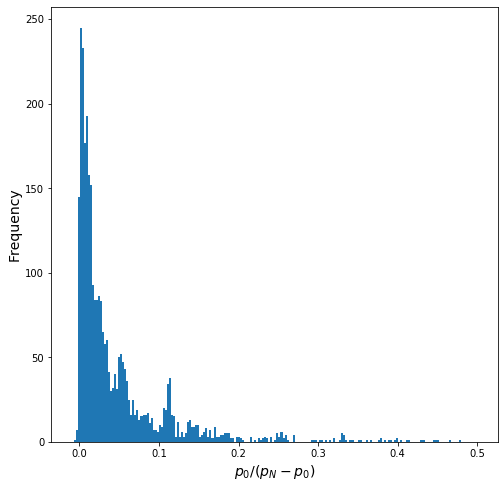

In [96]:
low_press_perc = []
for (i, material) in enumerate(material_gas_df.index):
        for (j, gas) in enumerate(material_gas_df.columns):
            if material not in material_gas_to_filename[gas].keys():
                continue
            filenames = material_gas_to_filename[gas][material]
            if len(filenames) < 1:
                continue

            for (k, filename) in enumerate(filenames):
                pressure, adsorption = read_isotherm_and_convert_units(filename)
                low_press_perc.append(pressure[0]/(pressure[-1]-pressure[0]))
                
fig = plt.figure(figsize=(8,8))
plt.hist(np.array(low_press_perc)[np.array(low_press_perc)!=0], bins=200, range=(-0.01,0.5))
plt.xlabel(r'$p_0 / (p_N - p_0)$', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

### We will use our own implementation to compute the Henry Coefficients of the adsorption isotherms.

In [97]:
def fit_henry_coefficients():
    messed_up_isotherms = []
    henry_coeff_df = pd.DataFrame(columns=['gas', 'material', 'henry_constant', 'filename', 'ok'])
    for (i, material) in enumerate(material_gas_df.index):
        for (j, gas) in enumerate(material_gas_df.columns):
            if material not in material_gas_to_filename[gas].keys():
                continue
            filenames = material_gas_to_filename[gas][material]
            if len(filenames) < 1:
                continue

            for (k, filename) in enumerate(filenames):
                # PyGAPS procedure:
                #pressure, adsorption = read_isotherm_and_convert_units(filename)
                #while pressure[0]/(pressure[-1]-pressure[0]) < 0.005:
                #    pressure = np.delete(pressure, 0)
                #    adsorption = np.delete(adsorption, 0)
                #isotherm = pygaps.PointIsotherm(
                #    pressure=pressure,
                #    loading=adsorption,
                #    material_name=material,
                #    material_batch='whatever',
                #    t_iso=298,
                #    adsorbate=gas)
                try:
                    #henry_coeff = pygaps.initial_henry_slope(isotherm, max_adsrms=0.01, logx=False, verbose=False)
                    henry_coeff = find_optimal_henry(filename, 0.02)[0]
                    henry_coeff_df = pd.concat([henry_coeff_df, pd.DataFrame(data={'gas': [gas.split('_')[0]], 'material': [material], 'henry_constant': [henry_coeff], 'filename': [filename], 'ok': [True]})], ignore_index=True)
                except Exception as e:
                    henry_coeff_df = pd.concat([henry_coeff_df, pd.DataFrame(data={'gas': [gas.split('_')[0]], 'material': [material], 'henry_constant': [np.nan], 'filename': [filename], 'ok': [False]})], ignore_index=True)
                    messed_up_isotherms.append(filename)
    return henry_coeff_df, messed_up_isotherms

henry_coeff_df, messed_up_isotherms = fit_henry_coefficients()

/home/sturlusa/my_projects/Environments/autoencoder37/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
/home/sturlusa/my_projects/Environments/autoencoder37/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


In [98]:
henry_coeff_df.sort_values(by='henry_constant', ascending=False).head(50)

,gas,material,henry_constant,filename,ok
1560,VNWKTOKETHGBQD-UHFFFAOYSA-N,NIST-MATDB-bbd809480ca8c8d0e4d066e70a9719d1,3.681461e+09,10.1016j.fluid.2014.08.020.Isotherm3,True
1559,VNWKTOKETHGBQD-UHFFFAOYSA-N,NIST-MATDB-bbd809480ca8c8d0e4d066e70a9719d1,3.573596e+09,10.1016j.fluid.2014.08.020.Isotherm4,True
1190,VNWKTOKETHGBQD-UHFFFAOYSA-N,NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,2.593508e+09,10.1016j.fluid.2014.08.020.Isotherm2,True
1191,VNWKTOKETHGBQD-UHFFFAOYSA-N,NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,2.485209e+09,10.1016j.fluid.2014.08.020.Isotherm1,True
1847,HSFWRNGVRCDJHI-UHFFFAOYSA-N,NIST-MATDB-297c8ffe0f482757db45335130e02770,3.374809e+08,10.1007s11224-012-0120-1.isotherm35,True
1821,HSFWRNGVRCDJHI-UHFFFAOYSA-N,NIST-MATDB-1733c0f5ae26290495f099f06d0dd880,1.824513e+08,10.1007s11224-012-0120-1.isotherm36,True
1800,XLYOFNOQVPJJNP-UHFFFAOYSA-N,NIST-MATDB-f55cae58cff61d336d8b65bece21175f,5.914156e+06,10.1002Aic.11362.Isotherm1,True
938,XLYOFNOQVPJJNP-UHFFFAOYSA-N,NIST-MATDB-991daf7313251e7e607e2bab2da57e33,4.226599e+06,10.1002Aic.11362.Isotherm2,True
1588,XLYOFNOQVPJJNP-UHFFFAOYSA-N,NIST-MATDB-bbd809480ca8c8d0e4d066e70a9719d1,1.592481e+06,10.1021La702466d.Isotherm3,True
162,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,5.226899e+05,10.1021Je800900a.Isotherm7,True


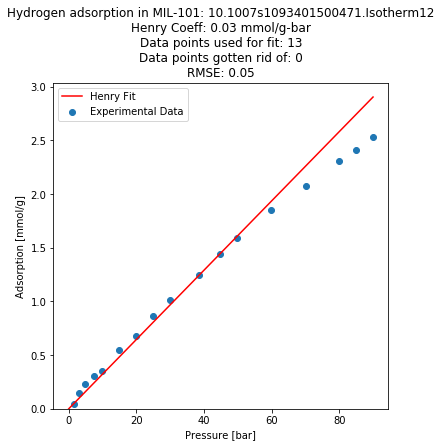

-----------------------------------------------------------


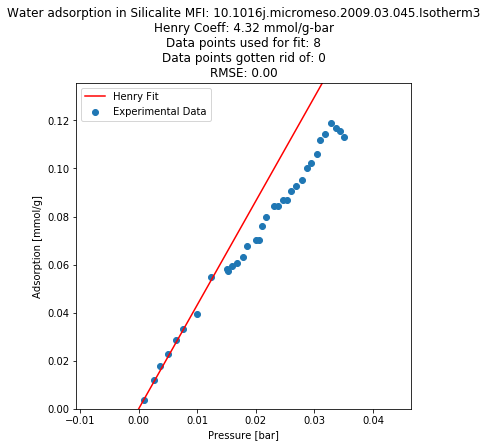

-----------------------------------------------------------


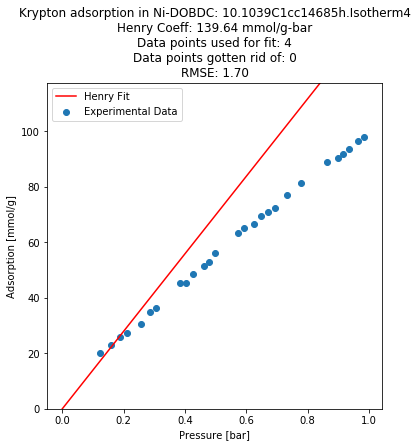

-----------------------------------------------------------


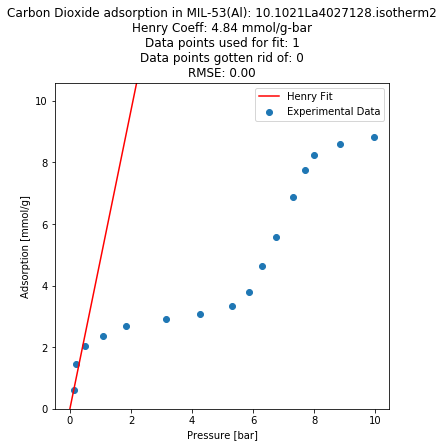

-----------------------------------------------------------


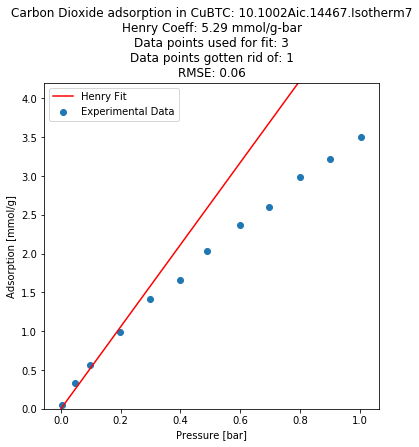

-----------------------------------------------------------


In [119]:
n = 5
for i in range(n):
    idx = random.choice(np.arange(len(henry_coeff_df.index[henry_coeff_df['ok']==True])))
    filename = henry_coeff_df.iat[idx, 3]
    try:
        henry, rmse, n, n_del = find_optimal_henry(filename, 0.02)
    except Exception as e:
        print('Oops! The isotherm was messed up!')
        print(e)
        continue
    gas = key_to_gas[henry_coeff_df.iat[idx, 0]]
    material = key_to_material[henry_coeff_df.iat[idx, 1]]
    pressure, adsorption = read_isotherm_and_convert_units(filename)
    fig = plt.figure(figsize=(6,6))
    plt.scatter(pressure, adsorption, label='Experimental Data')
    plt.plot([0, pressure[-1]], [0, pressure[-1] * henry], color='red', label='Henry Fit')
    plt.legend()
    plt.xlabel('Pressure [bar]')
    plt.ylabel('Adsorption [mmol/g]')
    plt.ylim([0, adsorption[-1]*1.2])
    plt.title('{} adsorption in {}: {}\nHenry Coeff: {:.2f} mmol/g-bar\nData points used for fit: {:d}\nData points gotten rid of: {:d}\nRMSE: {:.2f}'.format(gas, material, filename, henry, n, n_del, rmse))
    plt.show()
    print('-----------------------------------------------------------')

### Lets try analyzing the Henry Coefficients and get rid of outliers

In [124]:
def z_score_detection(henry_coeff_df, z_threshold):
    if 'z_score' in henry_coeff_df.columns:
        del henry_coeff_df['z_score']
    new_df = pd.DataFrame(columns=['z_score'])
    for gas in henry_coeff_df.gas.unique():
        henries = henry_coeff_df.loc[henry_coeff_df['gas'] == gas].loc[henry_coeff_df['ok'] == True]['henry_constant'].values
        mean_henry = np.nanmean(henries)
        stdev_henry = np.nanstd(henries)
        z_scores = [(henry - mean_henry) / stdev_henry for henry in henries]
        temp_df = pd.DataFrame(index=henry_coeff_df.loc[henry_coeff_df['gas'] == gas].loc[henry_coeff_df['ok'] == True].index,
                               data={'z_score': z_scores})
        new_df = pd.concat([new_df, temp_df], sort=False)
    henry_coeff_df = henry_coeff_df.join(new_df, how='left')
    return henry_coeff_df
henry_coeff_df = z_score_detection(henry_coeff_df, 1.5)

In [125]:
henry_coeff_df

,gas,material,henry_constant,filename,ok,z_score
0,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,0.466842,10.8888s10450-012-9407-1.Isotherm11,True,-0.060283
1,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,0.953853,10.8888s10450-012-9407-1.Isotherm1,True,-0.060264
2,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,0.290838,10.8888jp206959k.Isotherm17,True,-0.060290
3,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,2.612480,10.8888Ja909263x.Isotherm2,True,-0.060200
4,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,2.061060,10.8888j.cej.2011.01.096.isotherm4b,True,-0.060221
5,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,2.661803,10.1039C4ee01009d.Isotherm22,True,-0.060198
6,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,2.220755,10.1039C4ee01009d.Isotherm21,True,-0.060215
7,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,2.526879,10.1039C4ee01009d.Isotherm20,True,-0.060203
8,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,1.321715,10.1039C4ee01009d.Isotherm19,True,-0.060250
9,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,1.263680,10.1039C4ee01009d.Isotherm18,True,-0.060252


In [90]:
def isolation_forest_detection(henry_coeff_df, contamination=0.1):
    if 'isofor' in henry_coeff_df.columns:
        del henry_coeff_df['isofor']
    new_df = pd.DataFrame(columns=['isofor'])
    for gas in henry_coeff_df.gas.unique():
        henries = henry_coeff_df.loc[henry_coeff_df['gas'] == gas].loc[henry_coeff_df['ok'] == True]['henry_constant'].values
        isolation_forest = IsolationForest(max_samples='auto', contamination=contamination, behaviour='new')
        predictions = isolation_forest.fit_predict(henries.reshape(len(henries),1))
        temp_df = pd.DataFrame(index=henry_coeff_df.loc[henry_coeff_df['gas'] == gas].loc[henry_coeff_df['ok'] == True].index,
                               data={'isofor': predictions})
        new_df = pd.concat([new_df, temp_df], sort=False)
    henry_coeff_df = henry_coeff_df.join(new_df, how='left')
    return henry_coeff_df
henry_coeff_df = isolation_forest_detection(henry_coeff_df, 0.1)

In [91]:
print(np.sum(henry_coeff_df.isofor == -1))
henry_coeff_df.loc[henry_coeff_df.isofor == 1].sort_values(by='henry_constant', ascending=False).head(10)

318


,gas,material,henry_constant,filename,ok,isofor
1620,YXFVVABEGXRONW-UHFFFAOYSA-N,NIST-MATDB-b2cbe7a27aa1570f2ff2c04b82289f25,50293.215339,10.1021la010232r.Isotherm6,True,1
2755,XLYOFNOQVPJJNP-UHFFFAOYSA-N,NIST-MATDB-081a0818678716f502aee0b58ac1b30a,43790.161074,10.1021Jp805923k.Isotherm1,True,1
2231,XLYOFNOQVPJJNP-UHFFFAOYSA-N,NIST-MATDB-5b3ad76c63b1ce87a685648f69a4de28,42916.224683,10.1039C2dt31112g.Isotherm10,True,1
2230,XLYOFNOQVPJJNP-UHFFFAOYSA-N,NIST-MATDB-5b3ad76c63b1ce87a685648f69a4de28,30318.303634,10.1039C4cs00078a.Isotherm3,True,1
2754,XLYOFNOQVPJJNP-UHFFFAOYSA-N,NIST-MATDB-081a0818678716f502aee0b58ac1b30a,28462.606431,10.1021Jp805923k.Isotherm2,True,1
2086,XLYOFNOQVPJJNP-UHFFFAOYSA-N,NIST-MATDB-f5e80ffaaaf05f4ed655664fd22defb9,26933.323072,10.1016j.ces.2010.10.002.isotherm6,True,1
2607,YXFVVABEGXRONW-UHFFFAOYSA-N,NIST-MATDB-e8a1a82c4fe2ad952d1c107156f780f2,26872.270670,10.1016j.micromeso.2012.02.027.isotherm8,True,1
2904,XLYOFNOQVPJJNP-UHFFFAOYSA-N,NIST-MATDB-c235e2b9f0e0f3949e37b5ac3054f2ec,24221.698871,10.1021Ja060946u.Isotherm11,True,1
1811,URLKBWYHVLBVBO-UHFFFAOYSA-N,NIST-MATDB-f55cae58cff61d336d8b65bece21175f,22754.356067,10.1016j.cej.2011.07.051.Isotherm3-1,True,1
2075,XLYOFNOQVPJJNP-UHFFFAOYSA-N,NIST-MATDB-f5e80ffaaaf05f4ed655664fd22defb9,20077.678716,10.1021Jp503778m.Isotherm6,True,1


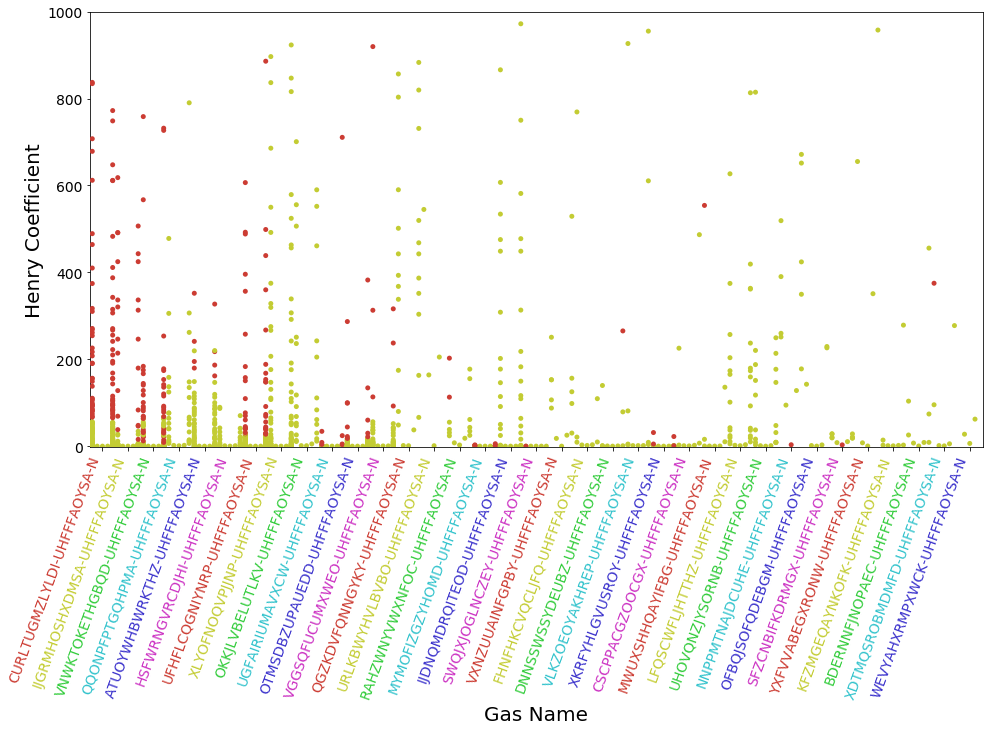

In [92]:
fig = plt.figure(figsize=(16,8))
pal = sns.hls_palette(6, l=.5, s=.6)
sp = sns.swarmplot(x='gas', y='henry_constant', hue="isofor", palette=pal, data=henry_coeff_df)
plt.ylim([-1, 1000])
ax = plt.gca()
ax.get_legend().remove()
plt.xticks(rotation=70, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Henry Coefficient', fontsize=20)
plt.xlabel('Gas Name', fontsize=20)
pal.as_hex()
n = len(pal)
for (i, xtick) in enumerate(ax.get_xticklabels()):
    xtick.set_color(pal[i%n])

In [68]:
def construct_henry_matrix(henry_coeff_df, method_for_multiple_isotherms):
    assert method_for_multiple_isotherms in ['median', 'mean']
    henry_matrix = np.empty(material_gas_df.shape)
    henry_matrix.fill(np.nan)

    for (i, material) in enumerate(material_gas_df.index):
        for (j, gas) in enumerate(material_gas_df.columns):
            ok_isotherms = henry_coeff_df.loc[(henry_coeff_df['gas'] == gas.split('_')[0]) & (henry_coeff_df['material'] == material) & (henry_coeff_df['isofor'] == 1)]
            if len(ok_isotherms['isofor'].values) != 0:
                if method_for_multiple_isotherms == 'mean':
                    henry_matrix[i, j] = np.mean(ok_isotherms['henry_constant'].values)
                elif method_for_multiple_isotherms == 'median':
                    henry_matrix[i, j] = np.median(ok_isotherms['henry_constant'].values)
    return henry_matrix

henry_matrix = construct_henry_matrix(henry_coeff_df, 'mean')

#### Run this for adsorption isotherm graphs of the files that we were not able to determine a Henry coefficient

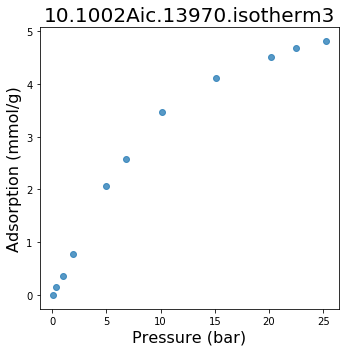

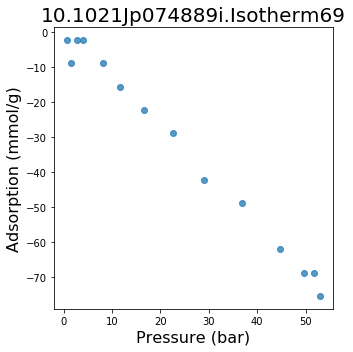

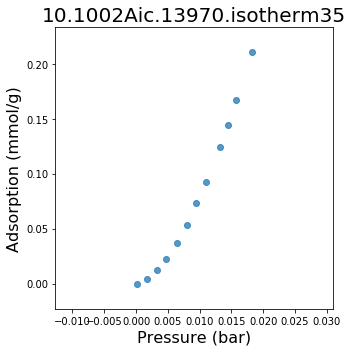

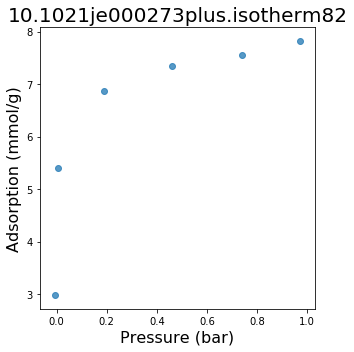

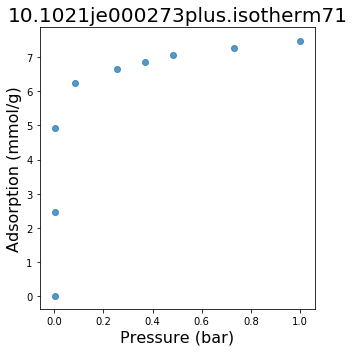

In [69]:
for messed_up_isotherm in messed_up_isotherms[:5]:
    pressure, adsorption = read_isotherm_and_convert_units(messed_up_isotherm)
    fig = plt.figure(figsize=(5,5))
    ax = plt.gca()
    ax.scatter(pressure, adsorption, marker='o', alpha=0.75)
    plt.xlabel('Pressure (bar)', fontsize=16)
    plt.ylabel('Adsorption (mmol/g)', fontsize=16)
    plt.title(messed_up_isotherm, fontsize=20)
    plt.tight_layout()
    plt.show()

In [70]:
with open('data/messed_up_isotherms.txt', 'w') as outfile:
    for mui in messed_up_isotherms:
        outfile.write('{}\n'.format(mui))

In [71]:
#henry_coeff_df['comment'] = ""
#henry_coeff_df.to_csv('henry_df.csv')
#henry_coeff_df.loc[henry_coeff_df['ok'] == True].sort_values(by='henry_constant').head(15)

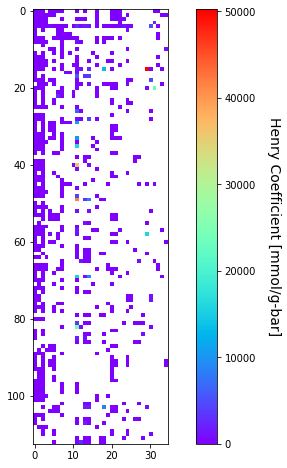

/home/sturlusa/my_projects/Environments/autoencoder37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less_equal
  # Remove the CWD from sys.path while we load stuff.


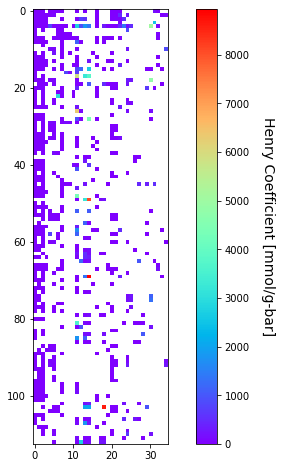

In [72]:
fig = plt.figure(figsize=(10,8))
ax = plt.gca()
plt.imshow(henry_matrix, interpolation='none', cmap='rainbow')
cbar = plt.colorbar()
cbar.set_label('Henry Coefficient [mmol/g-bar]', fontsize=14, rotation=270, labelpad=25)
#ax.axis('auto')

plt.show()

mask = np.less_equal(henry_matrix, 1e4)
new_matrix = henry_matrix * mask
fig = plt.figure(figsize=(10,8))
ax = plt.gca()
plt.imshow(new_matrix, interpolation='none', cmap='rainbow')
cbar = plt.colorbar()
cbar.set_label('Henry Coefficient [mmol/g-bar]', fontsize=14, rotation=270, labelpad=25)
#ax.axis('auto')

plt.show()

In [73]:
host = "adsorption.nist.gov"
url = "https://" + host + "/isodb/api/gases.json"
gas_data = json.loads(requests.get(url).content)

key_to_gas = {}
for gas in gas_data:
    key_to_gas[gas['InChIKey']] = gas['name']
gas_to_key = dict(map(reversed, key_to_gas.items()))

url = "https://" + host + "/isodb/api/materials.json"
material_data = json.loads(requests.get(url).content)

key_to_material = {}
for material in material_data:
    key_to_material[material['hashkey']] = material['name']
material_to_key = dict(map(reversed, key_to_material.items()))

In [74]:
henry_means = np.empty(henry_matrix.shape[1])
henry_medians = np.empty(henry_matrix.shape[1])
gas_names = np.empty(henry_matrix.shape[1], dtype=object)
henry_all_value = []
henry_all_gas = []
henry_all_mof = []
for (i, gas) in enumerate(material_gas_df.columns):
    henry_means[i] = np.nanmean(henry_matrix[:,i])
    henry_medians[i] = np.nanmedian(henry_matrix[:,i])
    gas_names[i] = key_to_gas[gas.split('_')[0]] + '_' + gas.split('_')[1]
    for (j, material) in enumerate(material_gas_df.index):
        henry_all_value.append(henry_matrix[j, i])
        henry_all_gas.append(key_to_gas[gas.split('_')[0]] + '_' + gas.split('_')[1])
        henry_all_mof.append(key_to_material[material])

henry_df_condensed = pd.DataFrame({'gas_name': gas_names, 'mean': henry_means, 'median': henry_medians})
henry_df = pd.DataFrame({'gas_name': henry_all_gas, 'mof_name': henry_all_mof, 'Henry_coeff': henry_all_value})

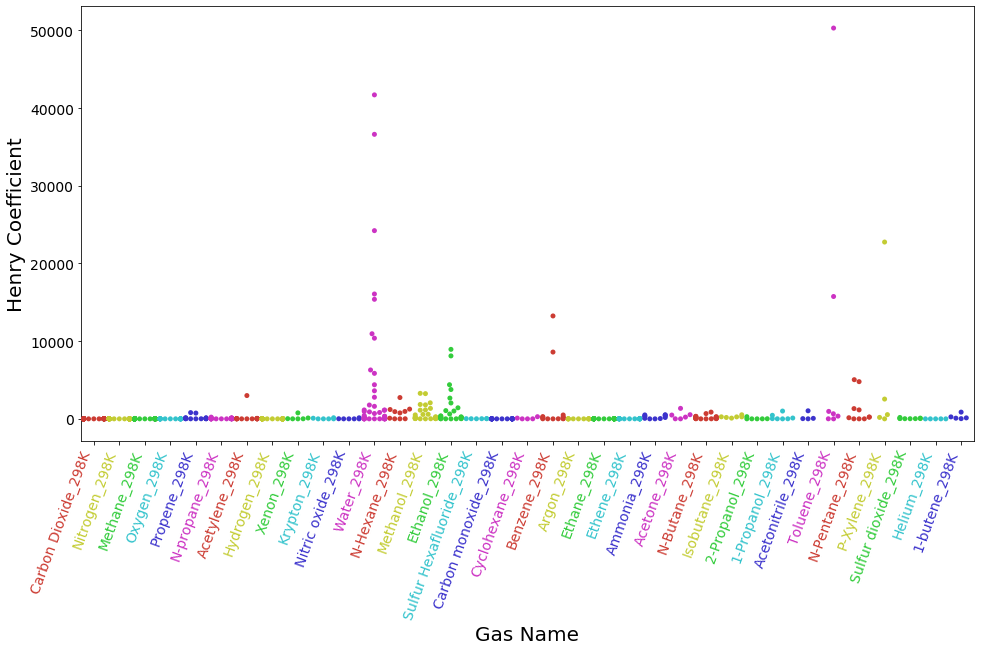

In [89]:
fig = plt.figure(figsize=(16,8))
pal = sns.hls_palette(6, l=.5, s=.6)
sp = sns.swarmplot(x='gas_name', y='Henry_coeff', hue="gas_name", palette=pal, data=henry_df)
#plt.ylim([-1, 1000])
ax = plt.gca()
ax.get_legend().remove()
plt.xticks(rotation=70, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Henry Coefficient', fontsize=20)
plt.xlabel('Gas Name', fontsize=20)
pal.as_hex()
n = len(pal)
for (i, xtick) in enumerate(ax.get_xticklabels()):
    xtick.set_color(pal[i%n])

In [76]:
henry_coeff_df.loc[henry_coeff_df['gas'] == gas_to_key['Water']].sort_values(by='henry_constant', ascending=False).head(10)

,gas,material,henry_constant,filename,ok,isofor
1800,XLYOFNOQVPJJNP-UHFFFAOYSA-N,NIST-MATDB-f55cae58cff61d336d8b65bece21175f,5.914156e+06,10.1002Aic.11362.Isotherm1,True,-1
938,XLYOFNOQVPJJNP-UHFFFAOYSA-N,NIST-MATDB-991daf7313251e7e607e2bab2da57e33,4.226599e+06,10.1002Aic.11362.Isotherm2,True,-1
1588,XLYOFNOQVPJJNP-UHFFFAOYSA-N,NIST-MATDB-bbd809480ca8c8d0e4d066e70a9719d1,1.592481e+06,10.1021La702466d.Isotherm3,True,-1
3095,XLYOFNOQVPJJNP-UHFFFAOYSA-N,NIST-MATDB-16d2ea75949f753ebc0daffccae0ed52,2.731331e+05,10.1002anie.201506345.Isotherm6,True,-1
2567,XLYOFNOQVPJJNP-UHFFFAOYSA-N,NIST-MATDB-b76bbf3e404395a8b5d1b9ec08bf2d8f,1.811730e+05,10.1021Je800900a.Isotherm63,True,-1
2161,XLYOFNOQVPJJNP-UHFFFAOYSA-N,NIST-MATDB-dd648c6388274576eaa6f506d849b3f9,1.467809e+05,10.1021La302537d.Isotherm39,True,-1
2566,XLYOFNOQVPJJNP-UHFFFAOYSA-N,NIST-MATDB-b76bbf3e404395a8b5d1b9ec08bf2d8f,1.460269e+05,10.1021Je800900a.Isotherm64,True,-1
2160,XLYOFNOQVPJJNP-UHFFFAOYSA-N,NIST-MATDB-dd648c6388274576eaa6f506d849b3f9,1.409930e+05,10.1021La302537d.Isotherm40,True,-1
224,XLYOFNOQVPJJNP-UHFFFAOYSA-N,NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,1.307122e+05,10.1021Je800900a.Isotherm54,True,-1
2074,XLYOFNOQVPJJNP-UHFFFAOYSA-N,NIST-MATDB-f5e80ffaaaf05f4ed655664fd22defb9,6.014357e+04,10.1021Jp503778m.Isotherm7,True,-1


In [77]:
def prune_matrix(henry_matrix, min_data_points, verbose=True):
    keep_row = np.ones(henry_matrix.shape[0], dtype=bool)
    keep_column = np.ones(henry_matrix.shape[1], dtype=bool)
    nb_kept_rows_and_columns = np.sum(keep_row) + np.sum(keep_column)
    gases_cut = 0
    materials_cut = 0
    count = 0

    while True:
        for i_row in range(henry_matrix.shape[0]):
            if np.count_nonzero(~np.isnan(henry_matrix[i_row, keep_column])) < min_data_points:
                keep_row[i_row] = False

        for i_column in range(henry_matrix.shape[1]):
            if np.count_nonzero(~np.isnan(henry_matrix[keep_row, i_column])) < min_data_points:
                keep_column[i_column] = False

        if nb_kept_rows_and_columns == (np.sum(keep_row) + np.sum(keep_column)):
            break

        nb_kept_rows_and_columns = np.sum(keep_row) + np.sum(keep_column)
        count += 1

    materials_cut = np.sum(~keep_row)
    gases_cut = np.sum(~keep_column)

    if verbose:
        print("Number of materials cut: {}" .format(materials_cut))
        print("Number of gases cut: {}" .format(gases_cut))
        print('The remaining dimensions of the matrix are {} by {}'.format(henry_matrix.shape[0]-materials_cut,henry_matrix.shape[1]-gases_cut))
        print('The number of iterations of sparsing the matrix: {}'.format(count))
        print('The sparsity of the resulting matrix is {:.1f}%'.format(
            100*np.count_nonzero(np.isnan(henry_matrix[keep_row, :][:, keep_column]))/np.size(henry_matrix[keep_row, :][:, keep_column])))
    
    return keep_row, keep_column

keep_row, keep_column = prune_matrix(henry_matrix, 5)
new_henry_matrix = henry_matrix[keep_row, :][:, keep_column]

Number of materials cut: 16
Number of gases cut: 1
The remaining dimensions of the matrix are 97 by 34
The number of iterations of sparsing the matrix: 1
The sparsity of the resulting matrix is 79.4%


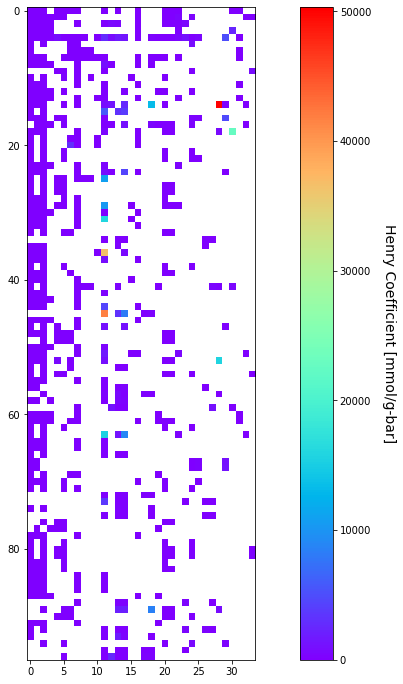

/home/sturlusa/my_projects/Environments/autoencoder37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less_equal
  # Remove the CWD from sys.path while we load stuff.


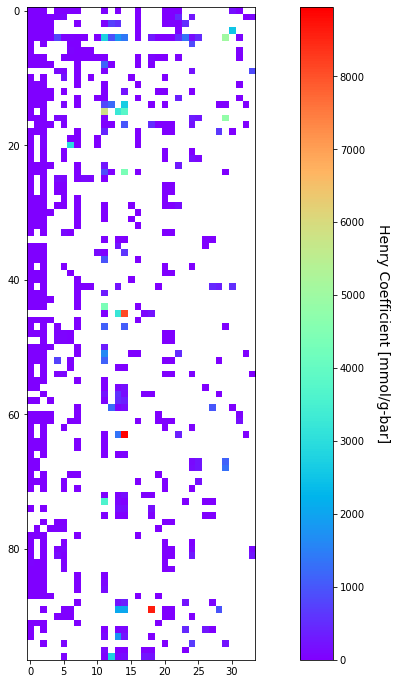

In [78]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
plt.imshow(new_henry_matrix, interpolation='none', cmap='rainbow')
cbar = plt.colorbar()
cbar.set_label('Henry Coefficient [mmol/g-bar]', fontsize=14, rotation=270, labelpad=25)
#ax.axis('auto')

plt.show()

mask = np.less_equal(new_henry_matrix, 1e4)
new_new_matrix = new_henry_matrix * mask
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
plt.imshow(new_new_matrix, interpolation='none', cmap='rainbow')
cbar = plt.colorbar()
cbar.set_label('Henry Coefficient [mmol/g-bar]', fontsize=14, rotation=270, labelpad=25)
#ax.axis('auto')

plt.show()

In [79]:
henry_matrix

array([[2.00881919e+00, 6.43667430e-01, 1.48827063e+00, ...,
        1.81925740e+01,            nan,            nan],
       [1.90283793e+01, 1.16426067e+00, 2.36537013e+00, ...,
                   nan, 4.27371383e-04, 8.67308742e+01],
       [2.62748612e+00, 3.58104110e-01, 3.81825358e+00, ...,
                   nan,            nan,            nan],
       ...,
       [           nan,            nan, 6.54002751e-01, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

In [80]:
henry_matrix_df = pd.DataFrame(data=np.array(new_henry_matrix),
                                 columns=[material_gas_df.columns[i] for i in np.arange(material_gas_df.shape[1])[keep_column]],
                                 index=[material_gas_df.index[i] for i in np.arange(material_gas_df.shape[0])[keep_row]],
                                dtype=float)

henry_matrix_df.to_csv('data/henry_matrix_df.csv')
henry_matrix_df.head(5)

,CURLTUGMZLYLDI-UHFFFAOYSA-N_298K,IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K,VNWKTOKETHGBQD-UHFFFAOYSA-N_298K,MYMOFIZGZYHOMD-UHFFFAOYSA-N_298K,QQONPFPTGQHPMA-UHFFFAOYSA-N_298K,ATUOYWHBWRKTHZ-UHFFFAOYSA-N_298K,HSFWRNGVRCDJHI-UHFFFAOYSA-N_298K,UFHFLCQGNIYNRP-UHFFFAOYSA-N_298K,FHNFHKCVQCLJFQ-UHFFFAOYSA-N_298K,DNNSSWSSYDEUBZ-UHFFFAOYSA-N_298K,...,IJDNQMDRQITEOD-UHFFFAOYSA-N_298K,NNPPMTNAJDCUHE-UHFFFAOYSA-N_298K,KFZMGEQAYNKOFK-UHFFFAOYSA-N_298K,BDERNNFJNOPAEC-UHFFFAOYSA-N_298K,YXFVVABEGXRONW-UHFFFAOYSA-N_298K,OFBQJSOFQDEBGM-UHFFFAOYSA-N_298K,URLKBWYHVLBVBO-UHFFFAOYSA-N_298K,RAHZWNYVWXNFOC-UHFFFAOYSA-N_298K,SWQJXJOGLNCZEY-UHFFFAOYSA-N_298K,VXNZUUAINFGPBY-UHFFFAOYSA-N_298K
NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,2.008819,0.643667,1.488271,NaN,12.326242,13.901850,0.001502,4.278958,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,184.515123,18.192574,NaN,NaN
NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,19.028379,1.164261,2.365370,0.207510,52.095266,80.817935,NaN,NaN,NaN,NaN,...,277.462875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000427,86.730874
NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,2.627486,0.358104,3.818254,0.188162,NaN,NaN,NaN,2.870710,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-1b85b1862d4e9cc2e0f46d0e2698ab79,2.829608,3.560541,1.161928,0.097778,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2545.488327,NaN,NaN,NaN
NIST-MATDB-991daf7313251e7e607e2bab2da57e33,4.219215,1.608393,0.735890,0.198392,801.831703,37.161951,66.660252,2.980532,20.891916,NaN,...,162.552306,523.199397,NaN,NaN,NaN,5039.506512,NaN,94.944295,NaN,NaN
